***Mounting Drive***

<hr>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [3]:
import sys
print(sys.path)

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


In [0]:
sys.path.append('/content/gdrive/My Drive/EVA/')
sys.path.append('/content/gdrive/My Drive/EVA/Models')
sys.path.append('/content/gdrive/My Drive/EVA/Transforms')

***Loading the python files from drive***


In [5]:
from imports_eva import *
import torch_transform as Tloader                 # Loading CIFAR10 data into train/test dataloaders
import resnet18 as mfile                          # ResNet18 Model architecture
import train_test_functions as ttfunc             # Model training and validation functions
import test_performance as tperform               # Class wise model accuracy and confusion matrix plot
import model_plots as mp                          # Plotting the Train/Test plots for loss and accuracy
import misclassified                              # Display misclassified images by the trained model
import Albumentation_transform as Aloader         # Albumentation transform
from torch_lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
#!pip install pytorch-gradcam
#!pip install albumentations
#!pip install torch-lr-finder


***Loading CIFAR data and creating test/train loaders with augumentations***
<hr>

In [6]:
trainloader, testloader = Aloader.train_test_loaders(128)   #arguments are batchsize, rotation value

Files already downloaded and verified
Files already downloaded and verified
Train Images count 50000
Test Images count 10000


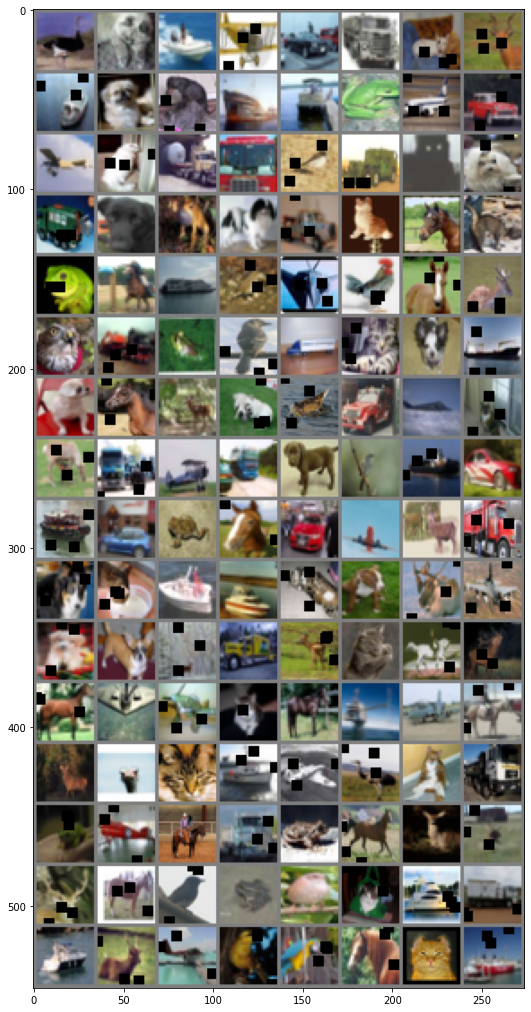

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

***Define the final target classes in CIFAR***


In [0]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

***Load RESNET18 model and print summary***
<hr>

In [8]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mfile.resnet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         Dropout2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         Dropout2d-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
        Dropout2d-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-3,momentum=0.9,)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader ,end_lr=5, num_iter=150, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


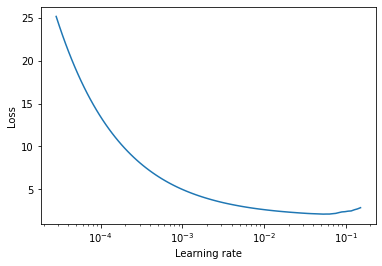

Best LR 0.0528843376619745


In [12]:
lr_finder.plot()
best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
print('Best LR',best_lr)

In [0]:
lr_finder.reset()

***Model Training***
---
<hr>

In [14]:
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
train_acc = []
train_loss = []
val_acc = []
val_loss = []

model =  mfile.resnet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer,verbose=True, patience=3)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    ta, tl   =  ttfunc.train(model, device, trainloader, optimizer, epoch)
    #train_acc.extend(ta)
    #train_loss.extend(tl)
    ta1, tl1 =  ttfunc.test(model, device, testloader, classes)
    #val_acc.extend(ta1)
    #val_loss.extend(tl1)
    scheduler.step(tl1[-1])
    print('')

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.4710098505020142 Batch_id=390 Accuracy=35.55: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 4580/10000 (45.80%)


EPOCH: 2


Loss=1.0532110929489136 Batch_id=390 Accuracy=51.69: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 6216/10000 (62.16%)


EPOCH: 3


Loss=0.8741633296012878 Batch_id=390 Accuracy=62.06: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6851/10000 (68.51%)


EPOCH: 4


Loss=0.7611417770385742 Batch_id=390 Accuracy=68.73: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7198/10000 (71.98%)


EPOCH: 5


Loss=0.8179715871810913 Batch_id=390 Accuracy=72.85: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7554/10000 (75.54%)


EPOCH: 6


Loss=1.0033676624298096 Batch_id=390 Accuracy=75.75: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7708/10000 (77.08%)


EPOCH: 7


Loss=0.6342872381210327 Batch_id=390 Accuracy=77.69: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7983/10000 (79.83%)


EPOCH: 8


Loss=0.5909603834152222 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 7976/10000 (79.76%)


EPOCH: 9


Loss=0.5077040791511536 Batch_id=390 Accuracy=79.76: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8024/10000 (80.24%)


EPOCH: 10


Loss=0.6347154378890991 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8155/10000 (81.55%)


EPOCH: 11


Loss=0.5697492361068726 Batch_id=390 Accuracy=81.05: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8255/10000 (82.55%)


EPOCH: 12


Loss=0.6580222845077515 Batch_id=390 Accuracy=81.24: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7954/10000 (79.54%)


EPOCH: 13


Loss=0.4848906099796295 Batch_id=390 Accuracy=82.01: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8258/10000 (82.58%)


EPOCH: 14


Loss=0.5194594264030457 Batch_id=390 Accuracy=82.22: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7922/10000 (79.22%)


EPOCH: 15


Loss=0.4080556035041809 Batch_id=390 Accuracy=82.59: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8059/10000 (80.59%)


EPOCH: 16


Loss=0.5881493091583252 Batch_id=390 Accuracy=82.91: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8326/10000 (83.26%)


EPOCH: 17


Loss=0.6342006325721741 Batch_id=390 Accuracy=83.12: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8310/10000 (83.10%)


EPOCH: 18


Loss=0.3957323133945465 Batch_id=390 Accuracy=83.72: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8054/10000 (80.54%)


EPOCH: 19


Loss=0.4515492022037506 Batch_id=390 Accuracy=83.51: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8042/10000 (80.42%)


EPOCH: 20


Loss=0.6245758533477783 Batch_id=390 Accuracy=83.86: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8359/10000 (83.59%)


EPOCH: 21


Loss=0.4051142632961273 Batch_id=390 Accuracy=84.00: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8334/10000 (83.34%)


EPOCH: 22


Loss=0.449084609746933 Batch_id=390 Accuracy=84.05: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8288/10000 (82.88%)


EPOCH: 23


Loss=0.4296044707298279 Batch_id=390 Accuracy=84.11: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8473/10000 (84.73%)


EPOCH: 24


Loss=0.3846204876899719 Batch_id=390 Accuracy=84.50: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8515/10000 (85.15%)


EPOCH: 25


Loss=0.47053462266921997 Batch_id=390 Accuracy=84.53: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8426/10000 (84.26%)


EPOCH: 26


Loss=0.3823392987251282 Batch_id=390 Accuracy=84.67: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8297/10000 (82.97%)


EPOCH: 27


Loss=0.49862536787986755 Batch_id=390 Accuracy=84.79: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8298/10000 (82.98%)

Epoch    27: reducing learning rate of group 0 to 5.0000e-03.

EPOCH: 28


Loss=0.288582980632782 Batch_id=390 Accuracy=90.49: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 8952/10000 (89.52%)


EPOCH: 29


Loss=0.23396353423595428 Batch_id=390 Accuracy=92.37: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9022/10000 (90.22%)


EPOCH: 30


Loss=0.14803357422351837 Batch_id=390 Accuracy=93.40: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9058/10000 (90.58%)


EPOCH: 31


Loss=0.14116156101226807 Batch_id=390 Accuracy=94.23: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9090/10000 (90.90%)


EPOCH: 32


Loss=0.18833670020103455 Batch_id=390 Accuracy=94.79: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9098/10000 (90.98%)


EPOCH: 33


Loss=0.08818966150283813 Batch_id=390 Accuracy=95.08: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)


EPOCH: 34


Loss=0.09731098264455795 Batch_id=390 Accuracy=95.72: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9078/10000 (90.78%)


EPOCH: 35


Loss=0.10328035056591034 Batch_id=390 Accuracy=96.03: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9077/10000 (90.77%)


EPOCH: 36


Loss=0.14085035026073456 Batch_id=390 Accuracy=96.12: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9092/10000 (90.92%)


EPOCH: 37


Loss=0.053936075419187546 Batch_id=390 Accuracy=96.69: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9111/10000 (91.11%)

Epoch    37: reducing learning rate of group 0 to 5.0000e-04.

EPOCH: 38


Loss=0.07508673518896103 Batch_id=390 Accuracy=97.27: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9163/10000 (91.63%)


EPOCH: 39


Loss=0.020127039402723312 Batch_id=390 Accuracy=97.48: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9161/10000 (91.61%)


EPOCH: 40


Loss=0.08531539142131805 Batch_id=390 Accuracy=97.56: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9160/10000 (91.60%)


EPOCH: 41


Loss=0.0777452141046524 Batch_id=390 Accuracy=97.73: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9162/10000 (91.62%)


EPOCH: 42


Loss=0.12208326905965805 Batch_id=390 Accuracy=97.84: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9155/10000 (91.55%)


EPOCH: 43


Loss=0.06228365749120712 Batch_id=390 Accuracy=97.81: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9158/10000 (91.58%)


EPOCH: 44


Loss=0.040064163506031036 Batch_id=390 Accuracy=97.99: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9158/10000 (91.58%)


EPOCH: 45


Loss=0.056654222309589386 Batch_id=390 Accuracy=98.02: 100%|██████████| 391/391 [03:13<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9177/10000 (91.77%)


EPOCH: 46


Loss=0.032201316207647324 Batch_id=390 Accuracy=98.00: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9159/10000 (91.59%)


EPOCH: 47


Loss=0.10584596544504166 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9158/10000 (91.58%)


EPOCH: 48


Loss=0.13258156180381775 Batch_id=390 Accuracy=98.09: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9163/10000 (91.63%)


EPOCH: 49


Loss=0.1228618398308754 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9160/10000 (91.60%)

Epoch    49: reducing learning rate of group 0 to 5.0000e-05.

EPOCH: 50


Loss=0.05144214630126953 Batch_id=390 Accuracy=98.32: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]



Test set: Average loss: 0.0021, Accuracy: 9173/10000 (91.73%)




In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d2): Dropout2d(p=0.05, inplace=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (d1): Dropout2d(p=0.1, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

***Checking test data performance/results***
<hr>

------------------------------------------------------------
Model accuracy on 10000 test images: 91.73%
------------------------------------------------------------
 
Category   - Accuracy
plane      - 91.90
car        - 96.80
bird       - 88.00
cat        - 81.40
deer       - 93.60
dog        - 86.50
frog       - 94.50
horse      - 94.00
ship       - 95.50
truck      - 95.10
 


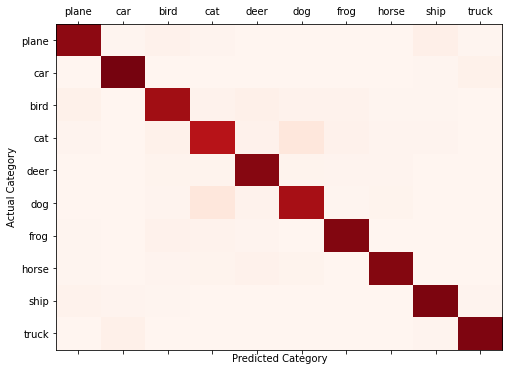

In [16]:
tperform.test_performance(model, testloader, device, classes)

**VAL/ACC PLOTS**

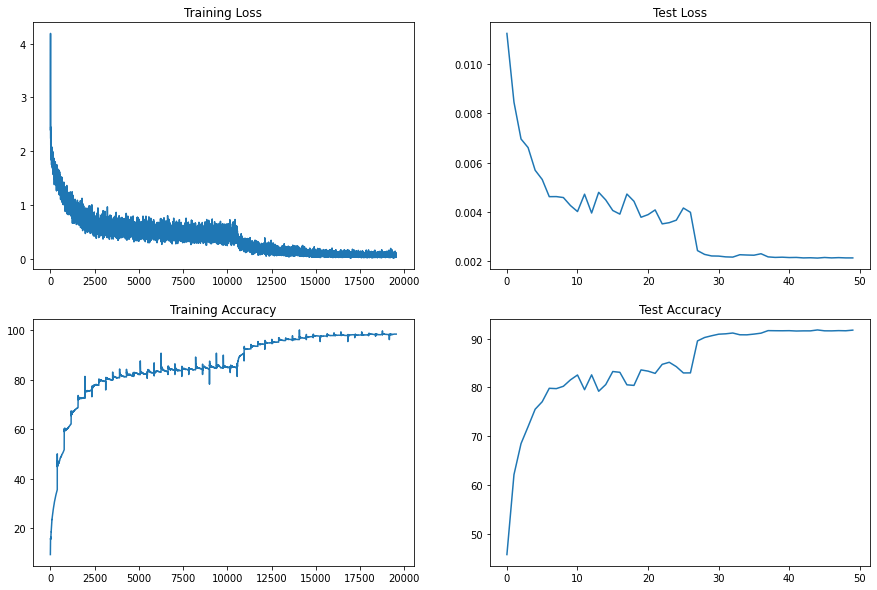

In [25]:
mp.train_testplots(trainloss = tl , trainacc = ta, testloss = tl1 , testacc = ta1)

***Show misclassified TEST images***
<hr>

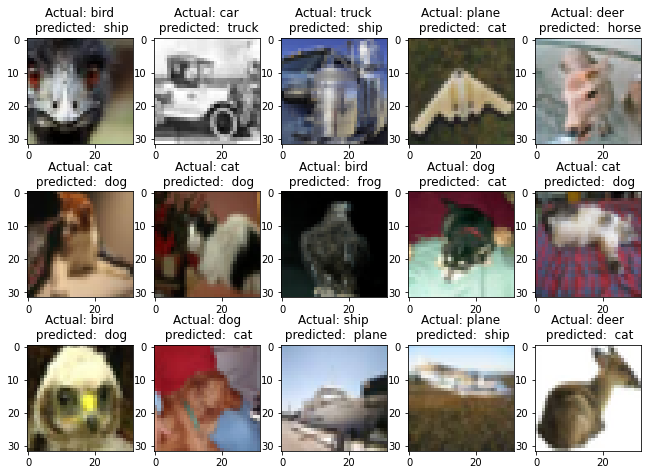

In [24]:
images, actuals, preds = misclassified.test_misclassified(model,device,testloader)
misclassified.plot_images(images, actuals, preds, classes)

**GRADCAM**

In [0]:
import requests
from io import BytesIO
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
# for inline graph plotting

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

def visualize_grad_cam(model):
	cuda = torch.cuda.is_available() # returns True/False
	device = torch.device("cuda" if cuda else "cpu")


	url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png' # sample image for GradCam testing on Custom Model
	response = requests.get(url)
	pil_img = PIL.Image.open(BytesIO(response.content))
	pil_img


	# print('pre-processing the input')
	torch_img = transforms.Compose([
	    transforms.Resize((32, 32)),
	    transforms.ToTensor()
	])(pil_img).to(device)
	normed_torch_img = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None]


	# print('loading the models:')
	# resnet = models.resnet18(pretrained=True)
	# vgg = models.vgg16(pretrained=True)
	# print('loading the models Finished!')

	configs = [
	    dict(model_type='resnet', arch=model, layer_name='layer3'), # My Model
	    # dict(model_type='resnet', arch=resnet, layer_name='layer3'), # Reference 
	    # dict(model_type='vgg', arch=vgg, layer_name='features_29') # Reference
	]

	for config in configs:
	    config['arch'].to(device).eval()

	cams = [
	    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
	    for config in configs
	]

	images = []
	for gradcam, gradcam_pp in cams:
	    mask, _ = gradcam(normed_torch_img)
	    heatmap, result = visualize_cam(mask, torch_img)

	    mask_pp, _ = gradcam_pp(normed_torch_img)
	    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
	    
	    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

	images = make_grid(images, nrow=5, scale_each=False, padding=10, pad_value=140, range=5)
	output_dir = '/home/prakash/Prakash/EVA4/Session-9/Notebooks'
	os.makedirs(output_dir, exist_ok=True)
	output_name = 'output.jpeg'
	output_path = os.path.join(output_dir, output_name)
	# print(output_path)
	save_image(images, output_path)
	grad_cam_output = PIL.Image.open(output_path)
	print(grad_cam_output.size)
	resized_output = grad_cam_output.resize((500, 120))
	
	plt.imshow(np.asarray(resized_output))

In [19]:
!pip install pytorch-gradcam

     |████████████████████████████████| 6.0MB 7.0MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-cp36-none-any.whl size=5269 sha256=8f329b50d4e8b9709d8222f14f13f72a39306b775dbc6ca2c85cde62042b819a
  Stored in directory: /root/.cache/pip/wheels/e8/1e/35/d24150a078a90ce0ad093586814d4665e945466baa89907300
Successfully built pytorch-gradcam


In [0]:
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
# for inline graph plotting

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

def visualize_grad_cam(model):
	cuda = torch.cuda.is_available() # returns True/False
	device = torch.device("cuda" if cuda else "cpu")


	url = 'https://www.cs.toronto.edu/~kriz/cifar-10-sample/dog4.png' # sample image for GradCam testing on Custom Model
	response = requests.get(url)
	pil_img = PIL.Image.open(BytesIO(response.content))
	pil_img


	# print('pre-processing the input')
	torch_img = transforms.Compose([
	    transforms.Resize((32, 32)),
	    transforms.ToTensor()
	])(pil_img).to(device)
	normed_torch_img = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None]


	# print('loading the models:')
	# resnet = models.resnet18(pretrained=True)
	# vgg = models.vgg16(pretrained=True)
	# print('loading the models Finished!')

	configs = [
	    dict(model_type='resnet', arch=model, layer_name='layer3'), # My Model
	    # dict(model_type='resnet', arch=resnet, layer_name='layer3'), # Reference 
	    # dict(model_type='vgg', arch=vgg, layer_name='features_29') # Reference
	]

	for config in configs:
	    config['arch'].to(device).eval()

	cams = [
	    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
	    for config in configs
	]

	images = []
	for gradcam, gradcam_pp in cams:
	    mask, _ = gradcam(normed_torch_img)
	    heatmap, result = visualize_cam(mask, torch_img)

	    mask_pp, _ = gradcam_pp(normed_torch_img)
	    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
	    
	    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

	images = make_grid(images, nrow=5, scale_each=False, padding=10, pad_value=140, range=5)
	output_dir = './Img'
	os.makedirs(output_dir, exist_ok=True)
	output_name = 'output.jpeg'
	output_path = os.path.join(output_dir, output_name)
	# print(output_path)
	save_image(images, output_path)
	grad_cam_output = PIL.Image.open(output_path)
	#print(grad_cam_output.size)
	resized_output = grad_cam_output.resize((1500, 520))
	
	plt.imshow(np.asarray(resized_output))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


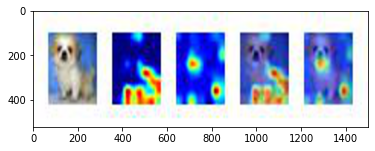

In [22]:
#from grad_cam_vis import visualize_grad_cam
%matplotlib inline

# Visualizing the GradCAM in the format of:
# Original Image, It's heatmap, heatmap of GradCAM++, Final Result, Final Result using GradCAM++
visualize_grad_cam(model)